# Machine learning german bank credit risk prediction
In this project, I will build a <b>machine learning model for credit risk prediction of German bank customers</b>. It involves <b>supervised learning (using a labeled training set) for classification</b>, where the <b>target</b> is <b>1</b> if the <b>customer</b> represents a <b>bad risk</b>, and <b>0</b> if they represent a <b>good risk</b>.

I will use the following <b>pipeline:</b>

<b>1. Define the business problem.</b><br>
<b>2. Collect the data and get a general overview of it.</b><br>
<b>3. Split the data into train and test sets.</b><br>
<b>4. Explore the data (exploratory data analysis)</b><br>
<b>5. Data cleaning and preprocessing.</b><br>
<b>6. Model training, comparison, selection and tuning.</b><br>
<b>7. Final production model testing and evaluation.</b><br>
<b>8. Conclude and interpret the model results.</b><br>

In <b>this notebook</b>, I will perform <b>machine learning modelling, covering steps 5 to 8 of the pipeline above</b>. The main <b>objective</b> here is to <b>build a model that can predict as many as possible bad risk customers, thus recall is the metric of interest</b>. Once I build this model, the <B>bank can make informed decisions that balance profit generation with prudent risk management</b>, ultimately benefiting both the company and its customers. Furthermore, I will approach these steps in more detail below, with an overview of them and the explanation of why I am making each decision. 

### Importing the libraries

In [22]:
# Data manipulation and visualization.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelling
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder, StandardScaler
from category_encoders import TargetEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer
from sklearn.base import clone

# Fixing bayesian search error.
np.int = int

# Filter warnings.
import warnings
warnings.filterwarnings('ignore')

# Utils
from notebooks.modelling_utils import *

### Reading the dataset

In [23]:
df = pd.read_csv('data/german_credit_data.csv')
# Dropping irrelevant column.
df.drop(columns=['Unnamed: 0'], inplace=True)

In [24]:
df.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


Sex and Risk can be expressed as binary features. Thus, I will set good as 1 and bad as 0 in Risk. In sex, I will set male as 1 and female as 0.

In [25]:
df['Sex'] = df['Sex'].map({'male': 1, 'female': 0})
df['Risk'] = df['Risk'].map({'bad': 1, 'good': 0})

### Split the data into train and test sets
- First of all, I will split the data into train and test sets.
- Test set is supposed to be data the model has never seen before.
- This split will avoid data leakage, which occurs when information from the test set or future data inadvertently leaks into the training process, leading to over-optimistic performance estimate, compromising the model's ability to generalize to new, unseen data.
- A good practice to protect the model against data leakage is perform fit_transform on training data and just transform on test data when applying preprocessing steps after the split.
- I will specify stratify=y so that the train_test_split function ensures that the splitting process maintains the same percentage of each target class in both the training and testing sets. This is particularly useful when dealing with imbalanced datasets, which is the case, as there are more bad risk customers.

In [26]:
X = df.drop(columns=['Risk'])
y = df['Risk'].copy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [27]:
print(f'Train predictor dataset shape: {X_train.shape}.')
print(f'Train target dataset shape: {y_train.shape}.')
print(f'Test predictor dataset shape: {X_test.shape}.')
print(f'Test target dataset shape: {y_test.shape}.')

Train predictor dataset shape: (800, 9).
Train target dataset shape: (800,).
Test predictor dataset shape: (200, 9).
Test target dataset shape: (200,).


In [28]:
print(f'Train target classes proportions: ')
print(y_train.value_counts(normalize=True))
print(f'\nTest target classes proportions:')
print(y_test.value_counts(normalize=True))

Train target classes proportions: 
Risk
0    0.7
1    0.3
Name: proportion, dtype: float64

Test target classes proportions:
Risk
0    0.7
1    0.3
Name: proportion, dtype: float64


The train-test-split was succesfull and each target class proportion was preserved in both sets.

# 5. Data cleaning and preprocessing
In order to fit machine learning algorithms, it is necessary to apply some transformations on the data.

- <b>Treat missing values:</b> Replace missing values with the mean, median or mode, dropping records or entire features with missings, etc.<br>
- <b>Numerical features:</b> Depending on the algorithm, it is necessary to <b>scale</b> the features using <b>normalization</b> or <b>standardization</b>. Some algorithms are sensitive to feature scaling because they use distance calculations or optimizations like gradient descent, which are affected by scale.<br>
- <b>Categorical features:</b> As machine learning algorithms make mathematical calculations, it is necessary to <b>encode categorical features</b> using <b>one-hot encoder</b>, <b>ordinal encoder</b>, <b>target encoder</b>, etc.
- <b>Outliers:</b> If outliers represent inconsistent information like measurement errors, they must be dropped from the data.
- In order to train <b>tree-based algorithms</b> like xgboost and random forest, <b>it is not necessary to scale the data</b>. However, as <b>I intend to test different models</b>, I will apply <b>target encoder</b> and <b>ordinal encoder</b> on <b>categorical features</b>, then <b>scale</b> these and the numerical ones using <b>standard scaler</b>. I will do this because some algorithms are sensitive to feature scaling (like logistic regression) and I want to compare all of the models at once. Furthermore, I will not apply one-hot encoder on categoric attributes because it can be detrimental to tree-based models (due to increased dimensionality and sparse representation) and, as I have a little amount of data (1000 rows), increasing dimensionality would favor overfitting.
- The dataset has some missing values in Saving accounts and Checking account. I will replace them with mode. Dropping the null values it's not a good choice because I have a little amount of data (just 1000 rows). The same for outliers, which I will not drop, once they don't represent inconsistent information.

In [29]:
X_train.head()

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
828,47,1,2,free,NaN,little,8335,36,car
997,38,1,2,own,little,NaN,804,12,radio/TV
148,28,1,2,own,little,little,5371,36,furniture/equipment
735,29,0,0,own,NaN,moderate,3990,36,domestic appliances
130,24,0,2,own,NaN,moderate,8487,48,car


Checking missing values.

In [30]:
X_train.isna().sum()

Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     144
Checking account    316
Credit amount         0
Duration              0
Purpose               0
dtype: int64

Checking numerical features.

In [31]:
numerical_features = X_train.select_dtypes('number').columns.to_list()
print(f'There are {len(numerical_features)} numerical features. They are: {numerical_features}')

There are 5 numerical features. They are: ['Age', 'Sex', 'Job', 'Credit amount', 'Duration']


Checking categorical features cardinality and unique values.

In [32]:
categorical_features = X_train.select_dtypes('object').columns.to_list()

print(f'There are {len(categorical_features)} categorical features. They are: {categorical_features}')
print()

for feature in categorical_features:
    print(feature)
    print(f'Number of categories: {X_train[feature].nunique()}. They are:')
    print(X_train[feature].unique())
    print()

There are 4 categorical features. They are: ['Housing', 'Saving accounts', 'Checking account', 'Purpose']

Housing
Number of categories: 3. They are:
['free' 'own' 'rent']

Saving accounts
Number of categories: 4. They are:
[nan 'little' 'moderate' 'rich' 'quite rich']

Checking account
Number of categories: 3. They are:
['little' nan 'moderate' 'rich']

Purpose
Number of categories: 8. They are:
['car' 'radio/TV' 'furniture/equipment' 'domestic appliances' 'education'
 'repairs' 'vacation/others' 'business']



I will build the preprocessor below. As I intend to test different algorithms, the same preprocessor will be used for tree-based models and scale sensitive models. Thus, for categorical features, I will apply target encoder and ordinal encoder (to those with ordinal relationships) after imputing their missing values with mode. Then, I will apply standard scaler on both numeric and categoric attributes (after encoding) because scale sensitive models need this to perform well due to distance calculations and some optimizations algorithms like gradient descent they use for training. By doing this, Tree-based models will not be affected with feature scaling and it will be possible to train and evaluate all of the models at once.

In [33]:
target_encoder_features = ['Saving accounts', 'Checking account']
ordinal_encoder_features = ['Purpose', 'Housing']

In [34]:
ordinal_pipeline = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')), 
        ('ordinal_encoder', OrdinalEncoder()),
        ('std_scaler', StandardScaler())
        ]
        )

target_pipeline = Pipeline(
    steps=[
        ('target_encoder',TargetEncoder(cols=target_encoder_features)), 
        ('std_scaler', StandardScaler())
        ]
        )

preprocessor = ColumnTransformer(
    transformers=[
        ('ordinal', ordinal_pipeline, ordinal_encoder_features),
        ('target', target_pipeline, target_encoder_features),
        ('std_scaler', StandardScaler(), numerical_features)
        ], remainder='passthrough'
        )

In [35]:
X_train_prepared = preprocessor.fit_transform(X_train, y_train)
X_train_prepared.shape

(800, 9)

# 6. Model training, comparison, selection and tuning
- In this step, I intend to compare different models performances. In order to achieve this, I will use k-fold cross validation to train each one of them, evaluating the roc_auc_score. Accuracy is not a good metric, because the target is imbalanced. Moreover, I will do a stratified k-fold cross validation in order to maintain the target proportion on each fold, dealing with the imbalanced target as well.
- <b>K-fold cross-validation</b> is a technique used in machine learning to assess the performance of a model. It involves splitting the data into k equally sized subsets or folds. The model is then trained and evaluated k times, with each fold serving as the test set once while the remaining folds are used as the training set. The performance metrics from each iteration are averaged to provide an overall estimation of the model's performance.
- <b>We use k-fold cross-validation to:</b><br>
    <b>1.</b> Obtain a more reliable estimate of the model's performance by reducing the impact of data variability.<br>
    <b>2.</b> Assess the model's generalization ability by evaluating its performance on multiple independent datasets.<br>
    <b>3.</b> Ensure that the model is not overfitting or underfitting by evaluating its performance on different subsets of the data.<br>
    <b>4.</b> Facilitate hyperparameter tuning by comparing the performance of different parameter configurations.<br>
    <b>5.</b> Provide a more robust evaluation metric that helps in making informed decisions about the model's effectiveness and        suitability for deployment.<br>
<br>
- After selecting a model, I will tune its hyperparameters.
<br>
- <b>Hyperparameter tuning</b> refers to the process of selecting the optimal hyperparameters for a machine learning model. Hyperparameters are parameters that are set before the model is trained and directly influence its performance but are not learned from the data.

- <b>In hyperparameter tuning:</b><br>
    <b>1.</b> Different combinations of hyperparameters are tested to find the best configuration that maximizes the model's performance.<br>
    <b>2.</b> Techniques like grid search, random search, or Bayesian optimization are used to explore the hyperparameter space efficiently.<br>
    <b>3.</b> The goal is to find the hyperparameter values that lead to the best generalization and minimize overfitting.<br>
    <b>4.</b> Tuning hyperparameters can improve the model's accuracy, robustness, and ability to handle different datasets.<br>
    <b>5.</b> It requires a balance between computational resources, time, and the desired level of performance improvement.<br>

### Models to train and evaluate the performance:
<b>Logistic Regression</b><br>
- Logistic regression is a binary classifier that makes predictions by taking the logistic function of the weighted sum of input features. The logistic function outputs a probability value ranging from 0 to 1. If the probability is greater than 0.5 the instance is classified as positive, else negative. By training this model, we want to calculate the optimal weights of the input features minimizing the log-loss cost function.

<b>K-Nearest Neighbors</b><br>
- K-Nearest Neighbors is a classifier that classifies an instance as the majority class of its K nearest neighbors. It finds these neighbors by calculating the euclidean distance.

<b>Support Vector Machines</b><br>
- Support vector machines classify instances by taking the weighted sum of input features. If this sum is greater than 0, the instance is classified as positive, else negative. The main objective when training a SVM is to find a balance between maximizing the marginal distance while limiting margin violations. Furthermore, if the data is not linearly separable, the kernel trick can be used to transform the data to a higher dimension feature space, (without actually adding features to the data), such that the classes can become linearly separable.

<b>Random Forest</b><br>
- Random forest is an ensemble model. It combines multiple decision trees to make predictions. Each decision tree is trained on a random sample of the entire training set using bootstrap (bagging) and a random sample of the features too. After trained, an instance will be classified as the majority class predicted by all of the tree predictors.

<b>XGBoost</b>
- XGBoost is a gradient boosting framework, optimized. It combines multiple decision trees where each predictor tries to predict the residuals of the previous predictor in a sequential learning (boosting). XGBoost classifies an instance by summing up the output value of each tree predictor for this instance and taking the logistic function of it to get a probability value. If the probability value is greater than 0.5, the instance classified as positive, else negative.

Getting the models and evaluating their performances with stratified k-fold cross validation in order to choose the best one.

In [36]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Linear SVM': LinearSVC(),
    'SVM': SVC(),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier()
}

Logistic Regression results: 
--------------------------------------------------
Training score: 0.6407738095238096
Average validation score: 0.7561755952380952
Standard deviation: 0.05039534545754632
Training time: 0.00532 seconds

Linear SVM results: 
--------------------------------------------------
Training score: 0.637202380952381
Average validation score: 0.7556547619047619
Standard deviation: 0.048433813909557866
Training time: 0.03788 seconds

SVM results: 
--------------------------------------------------
Training score: 0.687797619047619
Average validation score: 0.7375744047619048
Standard deviation: 0.03108445380154829
Training time: 0.02345 seconds

K-Nearest Neighbors results: 
--------------------------------------------------
Training score: 0.7413690476190476
Average validation score: 0.6764508928571429
Standard deviation: 0.05469140357990755
Training time: 0.00199 seconds



Random Forest results: 
--------------------------------------------------
Training score: 1.0
Average validation score: 0.7485863095238094
Standard deviation: 0.044596151473358873
Training time: 0.31607 seconds

XGBoost results: 
--------------------------------------------------
Training score: 1.0
Average validation score: 0.7303943452380952
Standard deviation: 0.03350705918142098
Training time: 0.12317 seconds

Plotting the results: 


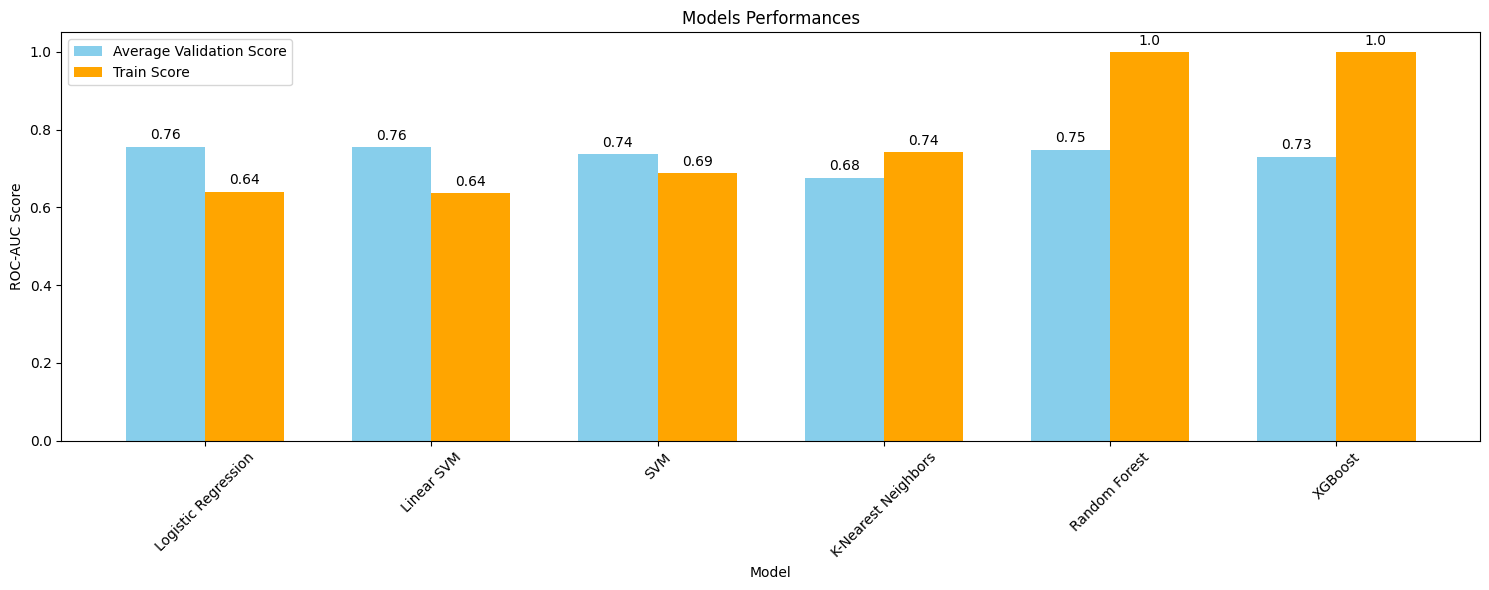

In [37]:
eval_df = evaluate_models_cv(models=models, X_train=X_train_prepared, y_train=y_train)

In [38]:
eval_df.sort_values(['Average Val Score'], ascending=False)

,Model,Average Val Score,Train Score
0,Logistic Regression,0.756176,0.640774
1,Linear SVM,0.755655,0.637202
4,Random Forest,0.748586,1.000000
2,SVM,0.737574,0.687798
5,XGBoost,0.730394,1.000000
3,K-Nearest Neighbors,0.676451,0.741369


Logistic Regression reached the best score. However, Random Forest is overfitting, there is a big difference between its validation and training errors. Actually, the training error is zero. Thus, this model presents low bias and high variance, and probably there is more space for performance improvement with it. So, as the difference between these models validation scores is small, I will go with Random Forest for hyperparameter tuning and final model evaluation.

### Hyperparameter tuning
As I intend to tune Random Forest model, I won't use GridSearchCV.

<b>Why not use grid search?</b> 
- Using grid search CV to tune Random Forest can be problematic due to its computational expense, limitations in granularity and adaptability, lack of consideration for interaction effects, inefficient exploration of the hyperparameter space, and inefficient allocation of computational resources. 
- Grid search exhaustively searches through all combinations of specified hyperparameters, it does not adapt its search based on the observed performance of previous hyperparameter configurations. Also, hyperparameters in Random Forest can have complex interactions, where the impact of one hyperparameter depends on the values of others. Grid search does not explicitly consider these interactions and evaluates hyperparameters independently. 
- As a result, more advanced optimization methods such as randomized search and Bayesian Optimization are often preferred for more efficient and effective hyperparameter tuning with Random Forest.<br>

Considering this, I will tune Random Forest using Bayesian Optimization.

<b>What is Bayesian Optimization?</b>
-  Bayesian optimization is an efficient and adaptive technique for finding the optimal combination of hyperparameters for a machine learning model. It uses probabilistic models to intelligently explore the hyperparameter space, balancing exploration and exploitation.

An important point here is to define class_weight hyperparameter. Then, the algorithm will assign different weights for minority (bad risk) and majority (good risk) class instances. Thus, the model will be penalized when mistakenly predicting a bad risk customer and also be able to learn the patterns in minority class data samples.

In [39]:
n_folds = 5
stratified_kfold = StratifiedKFold(n_splits=n_folds, shuffle=True, random_state=42)

search_space = {
    'n_estimators': Integer(100, 700),
    'criterion': Categorical(['gini', 'entropy', 'log_loss']),
    'max_depth': Integer(2, 16),
    'min_samples_split': Integer(2, 50),
    'min_samples_leaf': Integer(2, 25),
    'bootstrap': Categorical([True, False]),
    'class_weight': Categorical(['balanced', 'balanced_subsample']),
    'max_features': Categorical(['sqrt', 'log2', None])
}

bayesian_search = BayesSearchCV(estimator=RandomForestClassifier(), search_spaces=search_space, cv=stratified_kfold, n_iter=50, scoring='roc_auc', return_train_score=True, random_state=42)

In [40]:
bayesian_search.fit(X_train_prepared, y_train)

BayesSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
              estimator=RandomForestClassifier(), random_state=42,
              return_train_score=True, scoring='roc_auc',
              search_spaces={'bootstrap': Categorical(categories=(True, False), prior=None),
                             'class_weight': Categorical(categories=('balanced', 'balanced_subsample'), prior=None),
                             'criterion': Categorical(...
                             'max_depth': Integer(low=2, high=16, prior='uniform', transform='normalize'),
                             'max_features': Categorical(categories=('sqrt', 'log2', None), prior=None),
                             'min_samples_leaf': Integer(low=2, high=25, prior='uniform', transform='normalize'),
                             'min_samples_split': Integer(low=2, high=50, prior='uniform', transform='normalize'),
                             'n_estimators': Integer(low=100, high=700, prior='uniform', transform='normalize')})

In [41]:
print(f'The best params fund for Random Forest are: ')
bayesian_search.best_params_

The best params fund for Random Forest are: 


OrderedDict([('bootstrap', True),
             ('class_weight', 'balanced_subsample'),
             ('criterion', 'log_loss'),
             ('max_depth', 8),
             ('max_features', 'log2'),
             ('min_samples_leaf', 7),
             ('min_samples_split', 2),
             ('n_estimators', 322)])

Let's take a look into some results obtained by the bayesian search cv, specially for important parameters like class_weight, criterion, max_depth, min_samples_leaf, min_samples_split and n_estimators.

In [42]:
bayesian_search_results = pd.DataFrame(bayesian_search.cv_results_)
bayesian_search_results = bayesian_search_results[['rank_test_score', 'mean_test_score', 
'mean_train_score', 'param_class_weight', 
'param_criterion', 'param_max_depth', 
'param_min_samples_leaf', 'param_min_samples_split', 
'param_n_estimators']]
bayesian_search_results.sort_values(['rank_test_score']).head(10)

,rank_test_score,mean_test_score,mean_train_score,param_class_weight,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators
8,1,0.768676,0.903646,balanced_subsample,log_loss,8,7,2,322
28,2,0.768192,0.818863,balanced,entropy,7,25,7,100
13,3,0.768155,0.872842,balanced,entropy,8,11,22,688
15,4,0.767225,0.857013,balanced_subsample,entropy,10,11,37,105
22,5,0.767039,0.846975,balanced_subsample,log_loss,16,16,2,700
11,6,0.766592,0.818980,balanced,gini,10,25,13,694
3,7,0.766146,0.876025,balanced,gini,13,4,38,624
17,8,0.765923,0.819820,balanced_subsample,log_loss,16,25,2,700
48,9,0.765848,0.819020,balanced_subsample,entropy,16,25,8,700
49,10,0.765699,0.818599,balanced,gini,11,25,42,677


# 7. Final production model testing and evaluation
- In this final step, I intend to evaluate our tuned final model on test data (simulating production unseen data).
- As I'm dealing with an imbalanced classification problem, I will take a look at a bunch of metrics (auc-roc, recall, precision, etc.).
- Especially for this problem, recall is the most important metric as we want to identify as many bad risk customers as possible, minimizing the bank's risk when offering a credit service. Therefore, we can be more flexible with lower precision values, as false positives (customers who are good risk but were identified as bad risk) will not cause issues for the bank if their number is acceptable.

Getting the final tuned Random Forest model.

In [43]:
final_rf_clf = bayesian_search.best_estimator_

Using the preprocessor to transform the test predictor set. By applying just transform we avoid data leakage.

In [44]:
X_test_prepared = preprocessor.transform(X_test)
X_test_prepared.shape

(200, 9)

Making predictions.

In [45]:
final_predictions = final_rf_clf.predict(X_test_prepared)

### Evaluating the final tuned Random Forest model.

              precision    recall  f1-score   support

           0       0.83      0.74      0.78       140
           1       0.51      0.65      0.57        60

    accuracy                           0.71       200
   macro avg       0.67      0.69      0.68       200
weighted avg       0.74      0.71      0.72       200



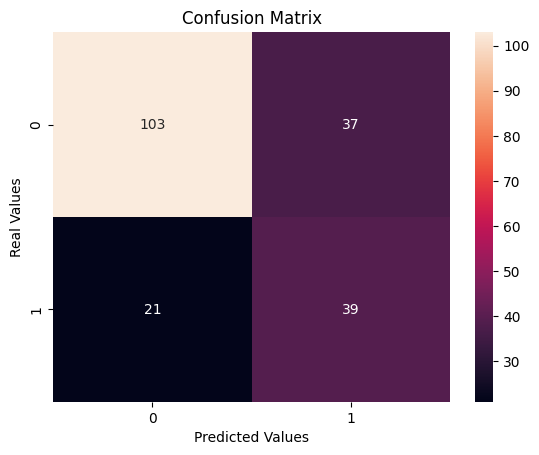

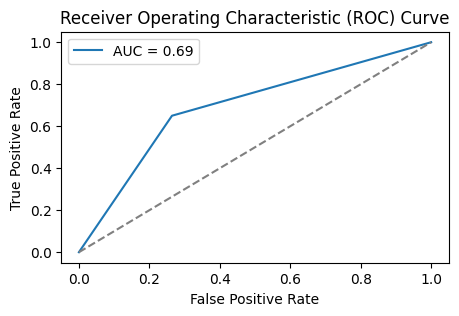

In [46]:
evaluate_classifier(y_test, final_predictions)

<b>The model presents a decent performance!</b>

<b>Recall Score (0.65):</b> The recall score, also known as the true positive rate or sensitivity, measures the proportion of actual positive cases (bad risk customers) that the model correctly identifies. The model correctly identifies 65% of the bad risk customers. In practical terms, looking at the confusion matrix, this means that it has defined correctly 39 out of 60 bad risk customers. Moreover, this is our metric of interest, and the model reached a good score!

<b>Precision Score (0.51):</b> The precision score quantifies the proportion of correctly predicted positive cases (bad risk customers) out of all instances predicted as positive by the model. Out of all the customers predicted as bad risk, 51% of them actually belong to this class. In practical terms, looking at the confusion matrix, this means that from 76 clients predicted as bad risk, 39 of them are actually risky. Thus, the precision score is not so good. However, predicting good risk customers as bad risk (false positives) will not cause many issues for the bank. Our goal is really to correctly identify a significant portion of bad risk customers, and the model does it.

<b>AUC Score (0.69):</b> The AUC (Area Under the Curve) score represents the overall performance of the model in distinguishing between positive (bad risk) and negative (good risk) instances. It measures the probability that the model will rank a randomly chosen positive instance higher than a randomly chosen negative instance. A higher AUC score indicates better performance. With an AUC score of 0.69, the model demonstrates a high ability to differentiate between bad and good risk customers.

### Interpreting the model results with feature importances
Finally, I will look at <b>feature importances</b>, in order to interpret Random Forest outcomes. An important task when performing supervised learning on a dataset is determining which features provide the most predictive power. By focusing on the relationship between only a few crucial features and the target label we simplify our understanding of the phenomenon, which is most always a useful thing to do.

Random Forest calculates feature importances by aggregating the average decrease in impurity (Gini or entropy) across all decision trees in the ensemble. Features that lead to more significant impurity reduction when used for splitting are considered more important. The final importance scores are normalized to sum up to 1 across all features. 

Finally, Let's look at feature importances below.

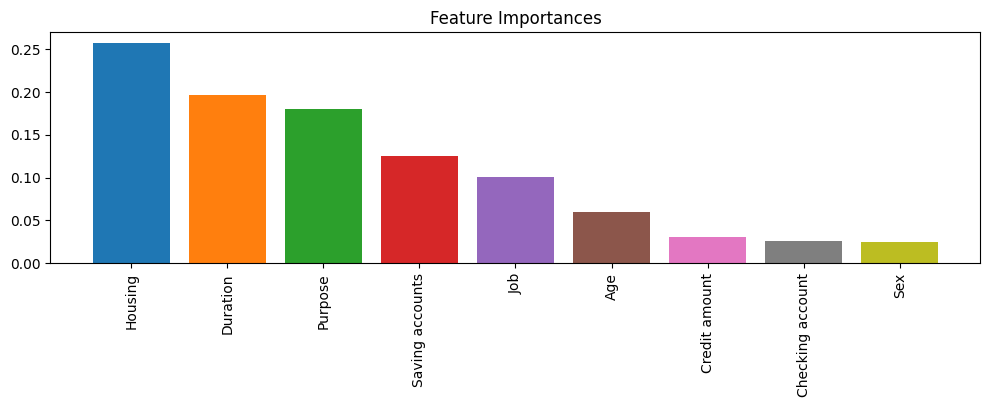

In [47]:
plot_feature_importances(final_rf_clf, df)

Housing, Duration, Purpose, Saving accounts and Job are the 5 features with the most predictive power for credit risk prediction. I saw on the eda that customers within some Housing, Purpose, Job and Saving accounts categories like free, vacation/others, highly skilled and little presented a tendency of being any of the credit risk labels (bad or good). Furthermore, I also saw that longer durations credit services are associated with higher credit amounts and thus, higher levels of risk. 

Finally, considering this, the model results are consistent and interpretable. Everything makes sense.

### Precision vs Recall trade-off
- My objective in building the model is to correctly predict as many bad risk customers as possible, such that the bank can make informed decisions and minimize risk when offering its credit services. Thus, I will examine the precision-recall curve to determine whether there is room for enhancing the recall metric without significantly compromising the precision score. This is a typical procedure when handling an imbalanced target in binary classification. Finally, I will do the predictions comparing the estimated probabilities of being bad risk (positive) with the threshold that provides the target recall value. If the estimated probability is greater than the threshold, the instance will be classified as positive, else negative.
- <b>Precision-recall trade-off:</b> The precision-recall trade-off involves finding a balance between precision and recall in a classification model. For Random Forest, adjusting the decision threshold can impact this trade-off. Lowering the threshold increases recall but may decrease precision, while raising it has the opposite effect. This trade-off is crucial for optimizing model performance, especially when dealing with imbalanced datasets.

Getting the model's estimated probabilities.

In [48]:
predicted_probas = final_rf_clf.predict_proba(X_test_prepared)

Plotting precision vs recall curve for different threshold values.

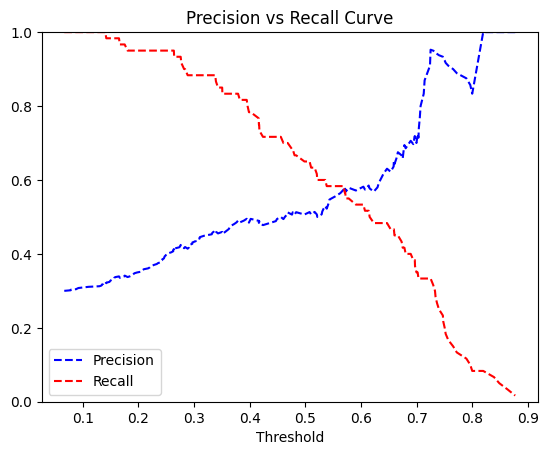

In [49]:
precision, recall, threshold = precision_vs_recall_curve(y_true=y_test, predicted_probas=predicted_probas)

There is space for enhancing the recall metric without significantly compromising the precision score.

Getting the threshold for a target metric value. The target metric for this case is recall because I intend to predict as many as possible bad risk customers (positive instances).

In [50]:
threshold_precision, threshold_recall, selected_threshold = get_threshold_metrics(precision=precision, 
recall=recall, threshold=threshold, 
target_metric='recall', target_metric_value=0.8)

For a threshold of 0.396079393065796:
Recall: 0.8
Precision: 0.4897959183673469


Wow! I can improve recall metric from 0.65 to 0.8 while decreasing precision just a little bit, from 0.51 to 0.49. Thus, I will do the predictions comparing the estimated probabilities of being bad risk (positive) with the threshold that provides 0.8 recall value. If the estimated probability is greater than the threshold, the instance will be classified as positive, else negative. Finally, I will evaluate the results after balancing this trade-off.

Making predictions.

In [51]:
threshold_predictions = (predicted_probas[:, 1] >= selected_threshold).astype(int)

Evaluating final model after balancing the precision-recall trade-off.

              precision    recall  f1-score   support

           0       0.88      0.64      0.74       140
           1       0.49      0.80      0.61        60

    accuracy                           0.69       200
   macro avg       0.69      0.72      0.68       200
weighted avg       0.76      0.69      0.70       200



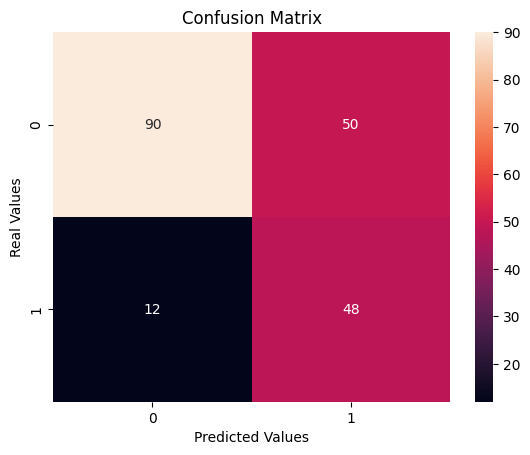

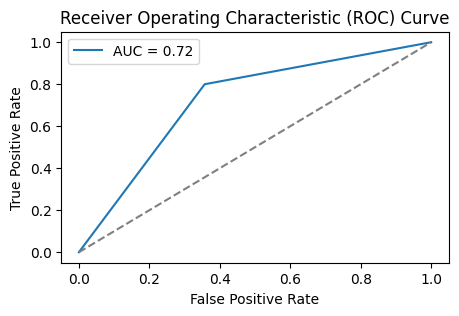

In [52]:
evaluate_classifier(y_test, threshold_predictions)

The results are great! By dealing with precision-recall trade-off, I was able to select a threshold value that improved the recall metric from 0.65 to 0.8 while decreasing just a bit the precision score, from 0.51 to 0.49. In practical terms, looking at the confusion matrix, it was possible to correctly predict 48 of the 60 bad risk customers. At the same time, I could also improve the ROC-AUC score from 0.69 to 0.72. Finally, the objective was achieved. Now, the bank can correctly identify 80% of the bad risk customers. Thus, my model solves the business problem by allowing the bank to make informed decisions, balancing profit generation with prudent risk management.

### Visualizing the probabilities
Below I get the top 10 customers with respect to highest and lowest Random Forest model's estimated probabilities of being bad risk. As we can see, the model results are coherent! Sometimes it makes errors, but mostly it is correct with respect to risky clients.

Top 10 customers with highest model's estimated probabilities of being bad risk.

In [53]:
bad_risk_probas = predicted_probas[:, 1]

probas_df = pd.concat([X_test, y_test], axis=1)
probas_df['Bad Risk Probas'] = bad_risk_probas
probas_df.sort_values(['Bad Risk Probas'], ascending=False).head(10)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,Bad Risk Probas
887,23,1,2,own,little,moderate,15672,48,business,1,0.876973
832,29,1,2,rent,little,little,11816,45,business,1,0.863209
11,24,0,2,rent,little,little,4308,48,business,1,0.848541
915,32,0,3,own,little,moderate,18424,48,vacation/others,1,0.838864
522,53,1,2,free,little,little,7119,48,furniture/equipment,1,0.819528
818,43,1,3,own,little,little,15857,36,vacation/others,0,0.799780
375,37,0,2,rent,little,little,7685,48,business,1,0.796258
831,23,0,2,rent,little,little,1216,18,car,1,0.789262
528,31,1,2,rent,little,little,2302,36,radio/TV,1,0.772098
1,22,0,2,own,little,moderate,5951,48,radio/TV,1,0.765430


Top 10 customers with lowest model's estimated probabilities of being bad risk.

In [54]:
probas_df.sort_values(['Bad Risk Probas'], ascending=True).head(10)

,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk,Bad Risk Probas
234,42,1,1,own,little,NaN,1544,4,radio/TV,0,0.066664
551,45,1,1,own,quite rich,NaN,1750,6,radio/TV,0,0.078086
473,36,1,3,own,NaN,NaN,1238,6,education,0,0.078507
947,38,1,3,own,NaN,NaN,2859,12,car,0,0.088224
682,33,1,2,own,little,NaN,1478,15,radio/TV,0,0.089819
219,64,0,2,own,little,NaN,1364,10,car,0,0.092245
159,34,1,1,own,NaN,NaN,1898,6,radio/TV,0,0.101378
379,52,0,1,own,moderate,NaN,362,6,car,0,0.110337
725,41,0,1,own,rich,NaN,250,6,car,0,0.129991
430,74,1,1,own,little,NaN,3448,5,business,0,0.133089


# 8. Conclusions
- In this project, I have built a Random Forest Classifier model for predicting German Bank's customers credit risks. The objective of the project was to build a model that was able to correctly identify as many as possible bad risk customers, focusing on the recall score. 
- The exploratory data analysis (EDA) provided a bunch of patterns and insights that guided the modelling step and answered a lot of questions about the problem.
- The main techniques used to deal with the imbalanced target were stratified split, stratified k-fold cross validation, class weight Random Forest model hyperparameter and precision-recall trade-off balancing. I didn't intend to use SMOTE, because it is prone to overfitting and a lot of experient data scientists don't recommend it.
- First, I have reached a 0.65 recall score by applying hyperparameter tuning on Random Forest. Then, I looked at the precision-recall trade-off, finding a threshold that provided a recall of 0.8. I made the predictions again, now comparing the model's estimated probabilities of the customer being bad risk with this threshold. If the probability was greater than it, the instance was classified as positive, else negative. By doing this, the sensitivity in fact went from 0.65 to 0.8 without significantly compromising the precision metric, which went from 0.51 to 0.49, just a little downgrade, incredible!
- Overall, the scores suggest that the model provides valuable results for the bank in predicting customers credit risk (bad or good). It identifies a high proportion of bad risk customers, specifically, 80% of them (0.8 recall score, the most important one for the analysis), has a decent proportion of correct predictions among the positive instances (0.49 precision score), and shows strong discrimination between bad and good risk customers (0.72 AUC score).
- Finally, the business problem was solved. I have found a lot of insights in the EDA step and built a model that is pretty useful for predicting customers credit risks. Now the bank can correctly identify 80% of the bad risk customers. Thus, it can make informed decisions, balancing profit generation with prudent risk management and minimizing potential financial losses caused when a borrower fails to repay a loan or a credit obligation.
- The next step is to deploy the model using CI/CD pipeline principles, with modular coding.

